In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import re
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [4]:
sentiment_labels = pd.read_csv("/content/sentiment_labels.txt", sep='|') #given phrases csv file
print("number of given phrases:",sentiment_labels.shape[0])

number of given phrases: 239232


In [5]:
sentiment_labels.head(2)

,phrase ids,sentiment values
0,0,0.5
1,1,0.5


In [6]:
dictionary = pd.read_csv("/content/dictionary.txt", sep="|", names=['phrase', 'phrase ids']) #phrase ids with phrases

In [7]:
dictionary.head(3)

,phrase,phrase ids
0,!,0
1,! ',22935
2,! '',18235


In [8]:
sentences = pd.read_csv("/content/datasetSentences.txt", sep="\t") #sentences
print("number of given sentences:",sentences.shape[0])

number of given sentences: 11855


In [9]:
sentences.head(2)

,sentence_index,sentence
0,1,The Rock is destined to be the 21st Century 's...
1,2,The gorgeously elaborate continuation of `` Th...


In [ ]:
data_split = pd.read_csv("/content/datasetSplit.txt") #data split file

In [11]:
data_split.head(2)

,sentence_index,splitset_label
0,1,1
1,2,1


In [12]:
#as we dont have labels for sentences,let's find the given  sentences in phrases dataframe and from that data frame we can get sentence lebels.
#matching sentences to phrases by merging them wherever sentence is same as phrase
sentence_phrase_merge = pd.merge(sentences, dictionary, left_on='sentence', right_on='phrase') #https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html

In [13]:
print("number of sentences after finding matching phrases:",sentence_phrase_merge.shape[0])

number of sentences after finding matching phrases: 11286


we can see that some of the sentences are missing,let's see what are those sentences:

In [14]:
sentence_phrase_merge.drop(['phrase','phrase ids'],axis=1,inplace=True)
pd.concat([sentence_phrase_merge,sentences]).drop_duplicates(keep=False).head()

,sentence_index,sentence
102,103,"But in Imax 3-D , the clichÃ©s disappear into ..."
173,174,-LRB- But it 's -RRB- worth recommending becau...
256,257,JirÃ­ Hubac 's script is a gem .
271,272,You would n't call The Good Girl a date movie ...
286,287,"An incendiary , deeply thought-provoking look ..."


We can see that sentences have some characters like LRB,RRB... and may be because of these characters our we cant able to find our sentences in phrase dataframe.So lets remove them.

In [18]:
# replacing the special characters with respective english characters
from tqdm import tqdm
cleaned_reviews = []
# tqdm is for printing the status bar
for sentence in tqdm(sentences['sentence'].values):
  sentence=sentence.replace('-LRB-','(')
  sentence=sentence.replace('-RRB-',')')
  sentence=sentence.replace('Â', '')
  sentence=sentence.replace('Ã©', 'e')
  sentence=sentence.replace('Ã¨', 'e')
  sentence=sentence.replace('Ã¯', 'i')
  sentence=sentence.replace('Ã³', 'o')
  sentence=sentence.replace('Ã´', 'o')
  sentence=sentence.replace('Ã¶', 'o')
  sentence=sentence.replace('Ã±', 'n')
  sentence=sentence.replace('Ã¡', 'a')
  sentence=sentence.replace('Ã¢', 'a')
  sentence=sentence.replace('Ã£', 'a')
  sentence=sentence.replace('\xc3\x83\xc2\xa0', 'a')
  sentence=sentence.replace('Ã¼', 'u')
  sentence=sentence.replace('Ã»', 'u')
  sentence=sentence.replace('Ã§', 'c')
  sentence=sentence.replace('Ã¦', 'ae')
  sentence=sentence.replace('Ã­', 'i')
  sentence=sentence.replace('\xa0', ' ')
  sentence=sentence.replace('\xc2', '')

  cleaned_reviews.append(sentence)

100%|██████████| 11855/11855 [00:00<00:00, 246068.10it/s]


In [19]:
sentences['cleaned'] = cleaned_reviews #adding these to sentence dataframe

In [22]:
sentences.head(2)

,sentence_index,sentence,cleaned
0,1,The Rock is destined to be the 21st Century 's...,The Rock is destined to be the 21st Century 's...
1,2,The gorgeously elaborate continuation of `` Th...,The gorgeously elaborate continuation of `` Th...


Lets match the sentences with phrases:

In [23]:
sentence_phrase_merge = pd.merge(sentences, dictionary, left_on='cleaned', right_on='phrase') #https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html
print("number of sentences:",sentence_phrase_merge.shape[0])

number of sentences: 11748


We can see that almost all the sentences got matched,only 100 of them are missing,if we check further and filter them accordingly,we can match all.But as of now let's proceed with this data.

In [24]:
#matching the sentences to data split i.e. train,test,cv data
sentence_phrase_split = pd.merge(sentence_phrase_merge, data_split, on='sentence_index')

In [25]:
#final data set with senetences and their labels
final= pd.merge(sentence_phrase_split, sentiment_labels, on='phrase ids')
print("final data shape:",final.shape)

final data shape: (11748, 7)


In [26]:
final.head(2)

,sentence_index,sentence,cleaned,phrase,phrase ids,splitset_label,sentiment values
0,1,The Rock is destined to be the 21st Century 's...,The Rock is destined to be the 21st Century 's...,The Rock is destined to be the 21st Century 's...,226166,1,0.69444
1,2,The gorgeously elaborate continuation of `` Th...,The gorgeously elaborate continuation of `` Th...,The gorgeously elaborate continuation of `` Th...,226300,1,0.83333


In [28]:
def labelling(label): #labelling the  sentiments
        if label <= 0.2: return 'very negative'
        if label <= 0.4: return 'negative'
        if label <= 0.6: return 'neutral'
        if label <= 0.8: return 'positive'
        return 'very positive'

In [29]:
final['sentiment'] = final['sentiment values'].map(labelling) #adding the sentiment labels  based on the sentiment values given

In [30]:
#dropping unnecessary columns
final.drop('phrase',axis=1,inplace=True)
final.drop('sentence_index',axis=1,inplace=True)
final.drop('sentence',axis=1,inplace=True)
final.drop('phrase ids',axis=1,inplace=True)
final.drop('sentiment values',axis=1,inplace=True)

In [31]:
print("final data frame:")
final.head(2)

final data frame:


,cleaned,splitset_label,sentiment
0,The Rock is destined to be the 21st Century 's...,1,positive
1,The gorgeously elaborate continuation of `` Th...,1,very positive


In [32]:
data = final.groupby('splitset_label') #getting the respective data groups based on splitset label
train_data = data.get_group(1)
cv_data = data.get_group(2)
test_data = data.get_group(3)
train_data.drop('splitset_label',axis=1,inplace=True)
cv_data.drop('splitset_label',axis=1,inplace=True)
test_data.drop('splitset_label',axis=1,inplace=True)
print("shape of train data:",train_data.shape)
print("shape of cv data:",cv_data.shape)
print("shape of test data:",test_data.shape)

shape of train data: (8454, 2)
shape of cv data: (2200, 2)
shape of test data: (1094, 2)


In [33]:
print("train data sample:")
train_data.head(2)

train data sample:


,cleaned,sentiment
0,The Rock is destined to be the 21st Century 's...,positive
1,The gorgeously elaborate continuation of `` Th...,very positive


# Exploratory Data Analysis

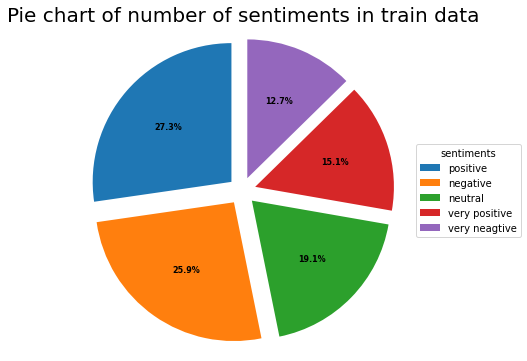

In [ ]:
#https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html#sphx-glr-gallery-pie-and-polar-charts-pie-features-py
explode = (0.1,0.1,0.1,0.1,0.1)
fig, ax = plt.subplots(figsize=(6,6))
wedges, texts, autotexts = ax.pie(train_data.sentiment.value_counts(),explode=explode, autopct='%1.1f%%',startangle=90)
ax.legend(wedges, train_data.sentiment.value_counts().index,
          title="sentiments",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=8, weight="bold")
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title("Pie chart of number of sentiments in train data",fontsize=20)
plt.show()

We can observe that data is imbalanced and sentences with positive sentiment are more in number and very positive sentences are least in number.

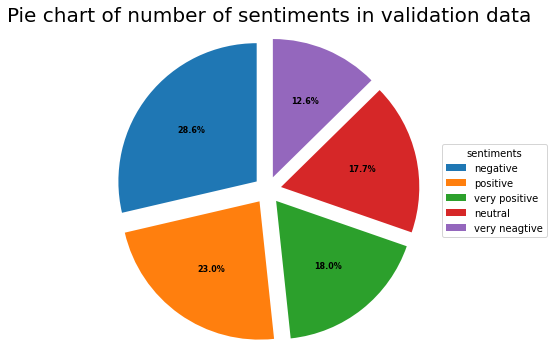

In [ ]:
#https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html#sphx-glr-gallery-pie-and-polar-charts-pie-features-py
explode = (0.1,0.1,0.1,0.1,0.1)
fig, ax = plt.subplots(figsize=(6,6))
wedges, texts, autotexts = ax.pie(cv_data.sentiment.value_counts(),explode=explode, autopct='%1.1f%%',startangle=90)
ax.legend(wedges, cv_data.sentiment.value_counts().index,
          title="sentiments",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=8, weight="bold")
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title("Pie chart of number of sentiments in validation data",fontsize=20)
plt.show()

**observation:**Distribution of labels in validation and train data is almost equal.

Let's check whether there is any realtion between length of sentence and the labels.

Text(0.5, 1.0, 'Kernel Distribution of length of sentences in train data')

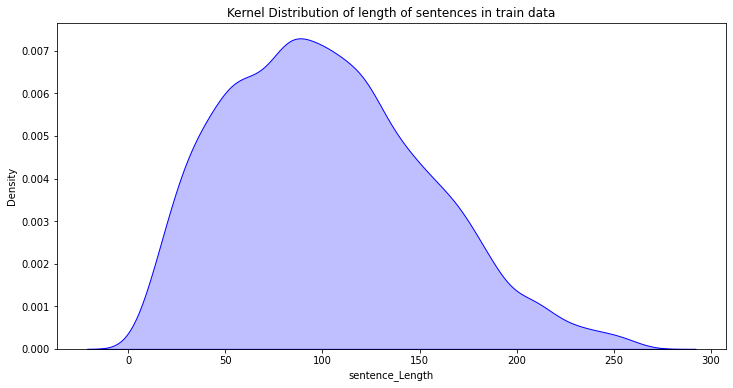

In [ ]:
train_data['sentence_Length']=train_data['cleaned'].apply(lambda x: len(x))
plt.figure(figsize=(12,6))
sns.kdeplot(train_data['sentence_Length'], shade=True, color="b").set_title('Kernel Distribution of length of sentences in train data')

We can see that most of sentences have length between 50 and 150. Let's look at the length of senences sentiment wise:

In [ ]:
p = train_data.groupby('sentiment').get_group('positive')
vp = train_data.groupby('sentiment').get_group('very positive')
n = train_data.groupby('sentiment').get_group('negative')
vn = train_data.groupby('sentiment').get_group('very neagtive')
nu = train_data.groupby('sentiment').get_group('neutral')

Text(0.5, 1.0, 'Kernel Distribution of length of sentences sentiment wise')

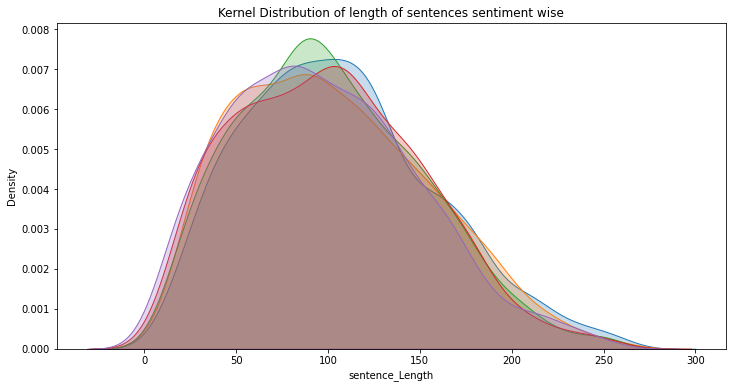

In [ ]:
plt.figure(figsize=(12,6))
sns.kdeplot(p['sentence_Length'], shade=True)
sns.kdeplot(vp['sentence_Length'], shade=True)
sns.kdeplot(n['sentence_Length'], shade=True)
sns.kdeplot(vn['sentence_Length'], shade=True)
sns.kdeplot(nu['sentence_Length'], shade=True).set_title('Kernel Distribution of length of sentences sentiment wise')

Distribution curves overlapped,so sentence length have no relation with labels.

# Sentiment wise Word Clouds:

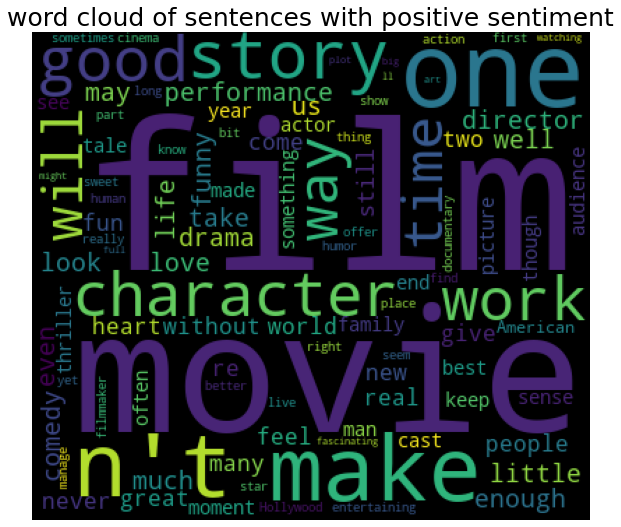

In [ ]:
from wordcloud import WordCloud
wc = WordCloud(max_words=100,width = 400, height = 350).generate(" ".join(p.cleaned.astype(str))) #word cloud for given texts
plt.figure(figsize = (10, 10))
plt.title('word cloud of sentences with positive sentiment',fontsize=25)
plt.imshow(wc)
plt.axis("off")
plt.show()

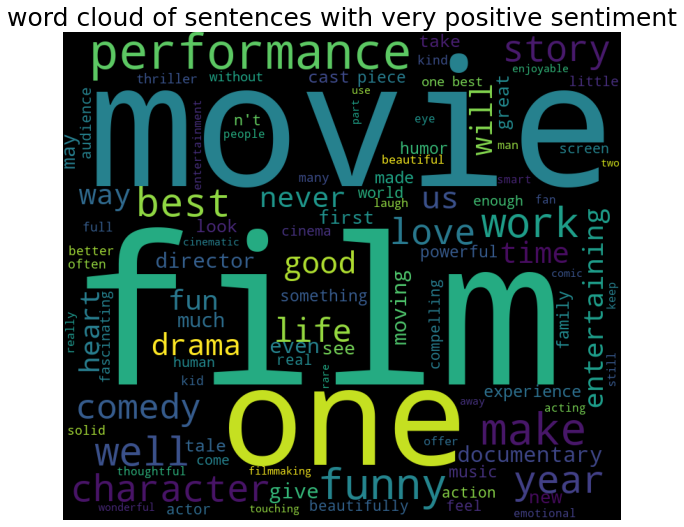

In [ ]:
from wordcloud import WordCloud
wc = WordCloud(max_words=100,width = 800, height = 700).generate(" ".join(vp.cleaned.astype(str)))
plt.figure(figsize = (10, 10))
plt.title('word cloud of sentences with very positive sentiment',fontsize=25)
plt.imshow(wc)
plt.axis("off")
plt.show()

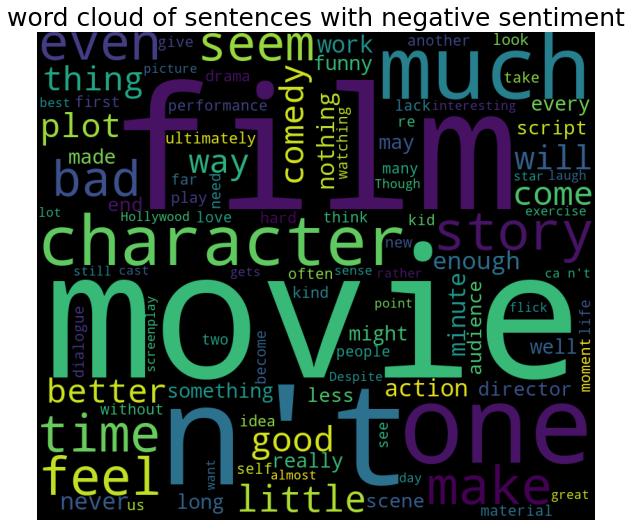

In [ ]:
from wordcloud import WordCloud
wc = WordCloud(max_words=100,width = 800, height = 700).generate(" ".join(n.cleaned.astype(str)))
plt.figure(figsize = (10, 10))
plt.title('word cloud of sentences with negative sentiment',fontsize=25)
plt.imshow(wc)
plt.axis("off")
plt.show()

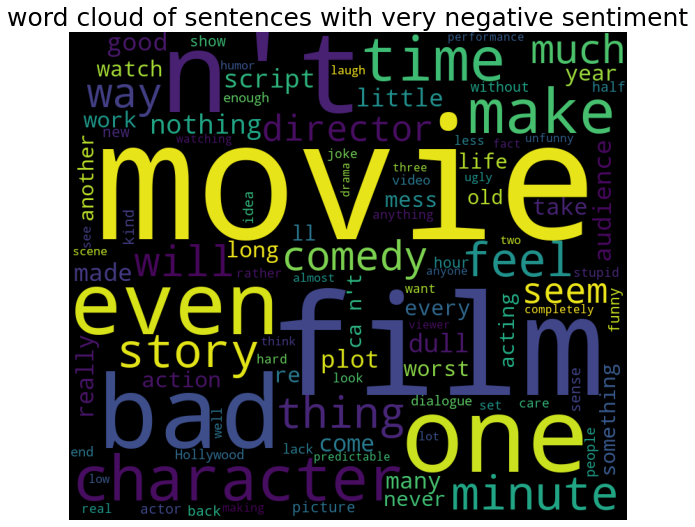

In [ ]:
from wordcloud import WordCloud
wc = WordCloud(max_words=100,width = 800, height = 700).generate(" ".join(vn.cleaned.astype(str)))
plt.figure(figsize = (10, 10))
plt.title('word cloud of sentences with very negative sentiment',fontsize=25)
plt.imshow(wc)
plt.axis("off")
plt.show()

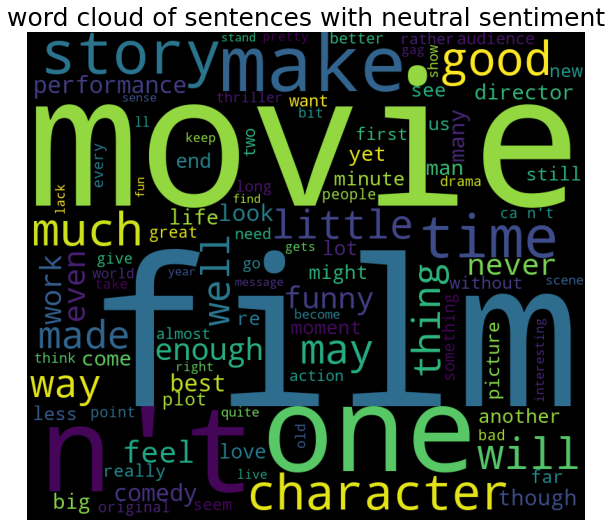

In [ ]:
from wordcloud import WordCloud
wc = WordCloud(max_words=100,width = 800, height = 700).generate(" ".join(nu.cleaned.astype(str)))
plt.figure(figsize = (10, 10))
plt.title('word cloud of sentences with neutral sentiment',fontsize=25)
plt.imshow(wc)
plt.axis("off")
plt.show()

We can observe that most of the words irrespective of sentiments are movie,film,character... so these are not much useful to us,so we can remove them in our modelling and also there are some words like good,better... which give positive meaning are present in negative sentiment sentences which indicates that either they are wrongly labelled or the labelling is almost independent of the individual words which contribute postive or negative sentiments.So in order to classify the sentiment labels, we have to take the meaning of whole sentence to consideration.

# Preprocessing

As there are lots of stop words and frequently occuring words like film,movie...etc. as they won't contribute much to our modelling.And also there are many special characters and numbers,let's clean them.

In [34]:
def decontracted(phrase): #function for replacing the words
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [35]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not' and adding the words : film, movie
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't", "film", "movie"]

In [36]:
def preprocess_text(text_data): #function for cleaning the text
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ') #remove next line characters
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent) #remove all special characters
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords) #remove stopwords and convert all words to lower case letters
        preprocessed_text.append(sent.lower().strip()) #strip the end and start of sentence
    return preprocessed_text

In [38]:
preprocessed_reviews = preprocess_text(train_data['cleaned'].values)

100%|██████████| 8454/8454 [00:00<00:00, 21126.29it/s]


In [39]:
train_data['preprocessed_reviews'] = preprocessed_reviews

In [41]:
train_data.head(2)

,cleaned,sentiment,preprocessed_reviews
0,The Rock is destined to be the 21st Century 's...,positive,rock destined 21st century new conan going mak...
1,The gorgeously elaborate continuation of `` Th...,very positive,gorgeously elaborate continuation lord rings t...


# Encoding of text data

In [42]:
#we use tfidf encoding of text data here
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=1,max_df = 1.0) #initialise tfidf vectorizer with the required values
vectorizer.fit(train_data['preprocessed_reviews'].values) #fit on train data
train_tfidf = vectorizer.transform(train_data['preprocessed_reviews'].values) #encode text data
print("Shape of matrix after tfidf encodig ",train_tfidf.shape)

Shape of matrix after tfidf encodig  (8454, 78562)


In [46]:
def y_labelling(label): #numerical labelling of the sentiment labels
        if label == 'very negative': return 0
        if label == 'negative': return 1
        if label == 'neutral': return 2
        if label == 'positive': return 3 
        return 4

In [ ]:
y_train = train_data['sentiment'].map(y_labelling)

# MODELLING

Logistic Regression with Grid search for finding the best parameters

In [49]:
#training simple LR model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
parameters = {'estimator__C' : [0.001, 0.01, 0.1, 1 ,10, 100] }
LR = LogisticRegression()
clf_LR = OneVsRestClassifier(LR) #one vs rest for multiclass classifier
gsv = GridSearchCV(clf_LR, parameters, cv=3, scoring='f1_micro', return_train_score=True) #using grid search with 3 fold cross validation 
gsv.fit(train_tfidf, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=OneVsRestClassifier(estimator=LogisticRegression(C=1.0,
                                                                        class_weight=None,
                                                                        dual=False,
                                                                        fit_intercept=True,
                                                                        intercept_scaling=1,
                                                                        l1_ratio=None,
                                                                        max_iter=100,
                                                                        multi_class='auto',
                                                                        n_jobs=None,
                                                                        penalty='l2',
                                                                        random_state=None

In [50]:
print('best parameters',gsv.best_params_)

best parameters {'estimator__C': 1}


# Cross Validation data

Predicting on validation data with the best model:

In [51]:
preprocessed_reviews = preprocess_text(cv_data['cleaned'].values) #cleaning the data
cv_data['preprocessed_reviews'] = preprocessed_reviews

100%|██████████| 2200/2200 [00:00<00:00, 18558.05it/s]


In [53]:
cv_tfidf = vectorizer.transform(cv_data['preprocessed_reviews'].values) #encoding the data using train tfidf values
print("Shape of cv data after tfidf encodig ",cv_tfidf.shape)

Shape of cv data after tfidf encodig  (2200, 78562)


In [ ]:
y_cv = cv_data['sentiment'].map(y_labelling)

Plotting Confusion Matrix for better visualisation of results

In [55]:
from sklearn.metrics import confusion_matrix
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [0,1,2,3,4]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [56]:
import matplotlib.pyplot as plt
best_lr = LogisticRegression(C=1) #best model after grid search cv
best_lr.fit(train_tfidf, y_train)  # training the model on train data
y_cv_pred = best_lr.predict(cv_tfidf)  #predicting on cv data

-------------------- Confusion matrix --------------------


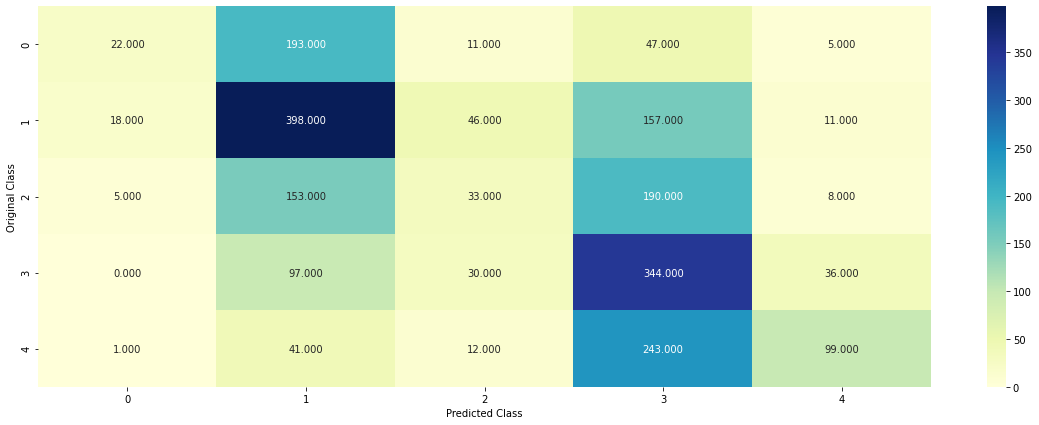

-------------------- Precision matrix (Columm Sum=1) --------------------


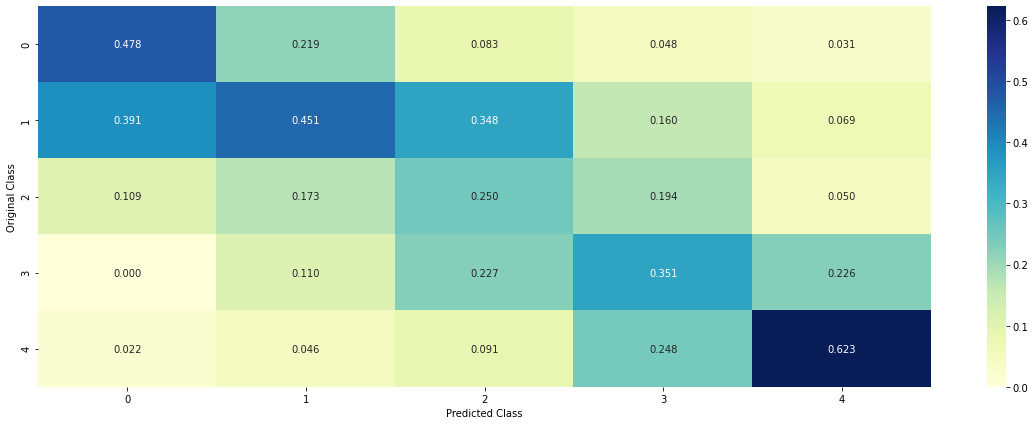

-------------------- Recall matrix (Row sum=1) --------------------


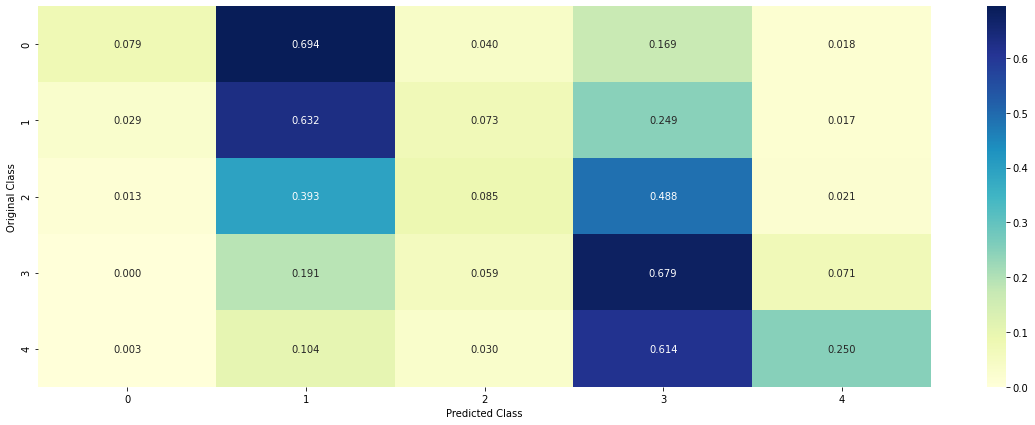

In [ ]:
plot_confusion_matrix(y_cv, y_cv_pred) #confusion matrix for validation data

# SCRAPPED DATA

Predicting scrapped data sentiments with the best model:

In [57]:
mobile_reviews = pd.read_csv("scrapped_reviews.csv") #scrapped mobile reviews from amazon site
mobile_reviews.head(3)

,mobile,review
0,OnePlus 8 (Onyx Black 8GB RAM+128GB Storage),"\n\n First of All, OnePlus phones are now Mad..."
1,OnePlus 8 (Onyx Black 8GB RAM+128GB Storage),"\n\n Great Performance, fingerprint is quite ..."
2,OnePlus 8 (Onyx Black 8GB RAM+128GB Storage),\n\n It's fantastic phone. Performance is exc...


In [59]:
preprocessed_reviews = preprocess_text(mobile_reviews['review'].values) #cleaning the data

100%|██████████| 100/100 [00:00<00:00, 4026.87it/s]


In [61]:
mobile_reviews['preprocessed_reviews'] = preprocessed_reviews
mobile_reviews.head(2)

,mobile,review,preprocessed_reviews
0,OnePlus 8 (Onyx Black 8GB RAM+128GB Storage),"\n\n First of All, OnePlus phones are now Mad...",first oneplus phones made india totally oneplu...
1,OnePlus 8 (Onyx Black 8GB RAM+128GB Storage),"\n\n Great Performance, fingerprint is quite ...",great performance fingerprint quite fast great...


In [63]:
test_tfidf = vectorizer.transform(mobile_reviews['preprocessed_reviews'].values) #encoding data
print("Shape of scrapped review data data after tfidf encodig ",test_tfidf.shape)

Shape of scrapped review data data after tfidf encodig  (100, 78562)


In [64]:
predictions = best_lr.predict(test_tfidf) #predicting on the reviews using the best model

In [ ]:
mobile_reviews['sentiment_labels'] = predictions #adding the predictins to dataframe

In [75]:
def senti_labelling(label): #numerical labelling of the sentiment labels
        if label == 0 : return 'very negative'
        if label == 1 : return 'negative'
        if label == 2 : return  'neutral'
        if label == 3 : return    'positive'
        return 'very positive'

In [ ]:
mobile_reviews['sentiment'] = mobile_reviews['sentiment_labels'].map(senti_labelling) #label the numerical sentiment values to sentiments
mobile_reviews.drop('review',axis=1,inplace=True) #dropping the unnecessary column
#mobile_reviews.head()

In [74]:
mobile_reviews.to_excel('reviews_sentiments.xlsx',index=False) #final excel file of reviews with predicted sentiment values

#Visualisations of the predictions:

In [78]:
p = mobile_reviews.groupby('sentiment').get_group('positive')
vp = mobile_reviews.groupby('sentiment').get_group('very positive')
n = mobile_reviews.groupby('sentiment').get_group('negative')
vn = mobile_reviews.groupby('sentiment').get_group('very negative')
nu = mobile_reviews.groupby('sentiment').get_group('neutral')

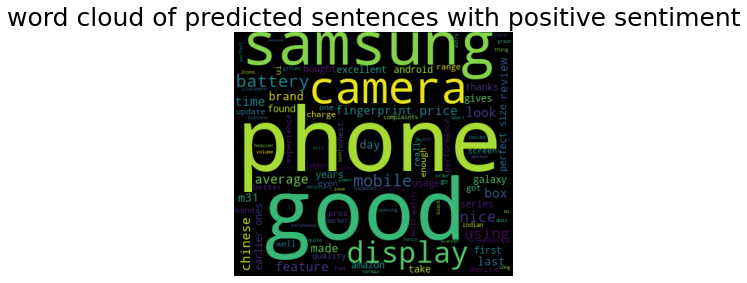

In [80]:
from wordcloud import WordCloud
wc = WordCloud(max_words=100,width = 400, height = 350).generate(" ".join(p.preprocessed_reviews.astype(str))) #word cloud for given texts
plt.figure(figsize = (5, 5))
plt.title('word cloud of predicted sentences with positive sentiment',fontsize=25)
plt.imshow(wc)
plt.axis("off")
plt.show()

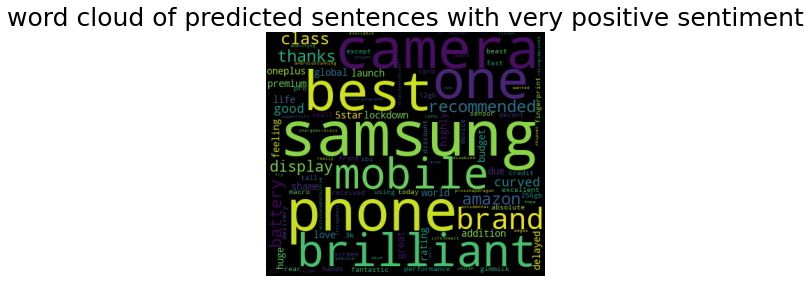

In [83]:
from wordcloud import WordCloud
wc = WordCloud(max_words=100,width = 400, height = 350).generate(" ".join(vp.preprocessed_reviews.astype(str))) #word cloud for given texts
plt.figure(figsize = (5, 5))
plt.title('word cloud of predicted sentences with very positive sentiment',fontsize=25)
plt.imshow(wc)
plt.axis("off")
plt.show()

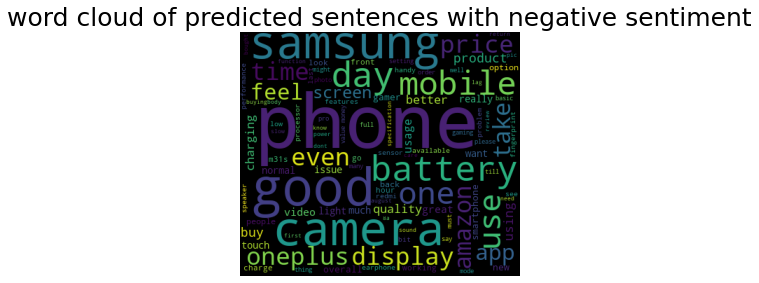

In [84]:
from wordcloud import WordCloud
wc = WordCloud(max_words=100,width = 400, height = 350).generate(" ".join(n.preprocessed_reviews.astype(str))) #word cloud for given texts
plt.figure(figsize = (5, 5))
plt.title('word cloud of predicted sentences with negative sentiment',fontsize=25)
plt.imshow(wc)
plt.axis("off")
plt.show()

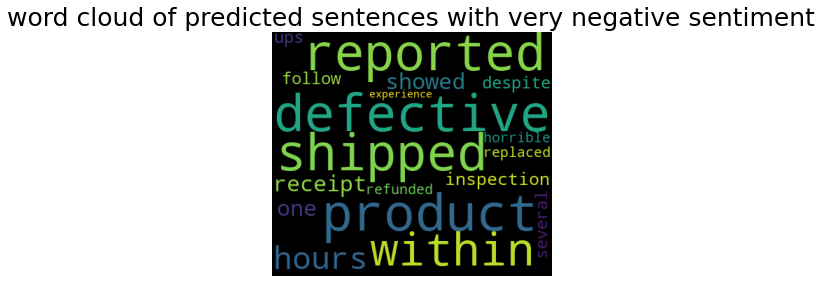

In [86]:
from wordcloud import WordCloud
wc = WordCloud(max_words=100,width = 400, height = 350).generate(" ".join(vn.preprocessed_reviews.astype(str))) #word cloud for given texts
plt.figure(figsize = (5, 5))
plt.title('word cloud of predicted sentences with very negative sentiment',fontsize=25)
plt.imshow(wc)
plt.axis("off")
plt.show()

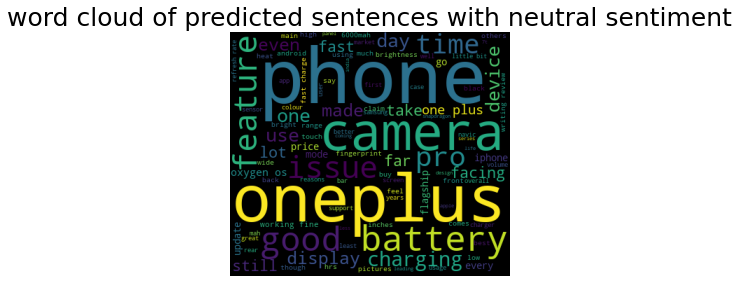

In [88]:
from wordcloud import WordCloud
wc = WordCloud(max_words=100,width = 400, height = 350).generate(" ".join(nu.preprocessed_reviews.astype(str))) #word cloud for given texts
plt.figure(figsize = (5, 5))
plt.title('word cloud of predicted sentences with neutral sentiment',fontsize=25)
plt.imshow(wc)
plt.axis("off")
plt.show()

#CONCLUSION :

From the word cloud predictions, we can see that:for sentences predicted as positive and very positive sentiment has words like good, better, best, brilliant are occuring more frequently, and for very negative and negative predictions also words like reported,defective are frequent and for neutral predictions, there arent many positive or negative sentiment words, which concludes that our simple Logistic Regression model's predictions are quite good. If we want the best performance we have to further analyse the data well and build coomplex models.